## Introduction
This tutorial will focus on how to use REST APIs to collect or send data. In particular, the tutorial will introduce how to use the Python ```Requests``` library to interact with APIs and how we can apply that knowledge to transfer data from Canvas LMS to Trello (a task management application). The second example will be show how we can use the data for simple data science tasks. There are many cases where we would want to access pieces of data from one data source and use it in another application. This can range from scraping data from online websites for data analysis to automating workflows between applications. 


## Tutorial Contents
We will be using several python libraries to query data from the Canvas LMS API and Trello API. To make API calls to the 2 APIs, we will use the Python ```Requests``` library. In transfering data from Canvas to Trello, we will make use of the ```random``` and ```html2text``` libraries to transform the data. The [Canvas LMS API](https://canvas.instructure.com/doc/api/index.html) allows users to interface with various information from the Canvas servers such as student courses, assignments, grades, etc. The [Trello API](https://developer.atlassian.com/cloud/trello/rest/api-group-actions/) allows users to get information from existing boards and to create new items in Trello. Lastly, we will use ```pandas``` to create a visualization of our assignment workload by month.

## Installing the libraries
To install the required libraries with pip, simply run the following commands in the terminal.

```
$ python -m pip install requests

$ python -m pip install random

$ python -m pip install html2text

$ python -m pip install pandas
```
After installing, run the following cell to import the libraries into the notebook.

In [33]:
import requests 
import random
import html2text
import pandas as pd

## Introduction to REST APIs

There are many ways to get data for data science. One of the key ways is through querying specific application endpoints. An **application programming interface** (API) is a software layer that allows 2 applications to communicate with each other through a set of defined protocols. For example, a website communicates to a backend server through an API to get the information it should display on the webpage. 

A REST (REpresentational State Transfer) API is a web API that follows the REST architectural style. Web APIs often use the client-server architecture for separation of concerns. The key aspect of REST is that requests are stateless. The server will not store any session data and each request must contain all the necessary information to use the endpoint. Endpoints are usually specified as urls with data being organized into different sub paths. Clients will send a request to the proper url to fetch/edit/delete a resource and the server will send back a response.



**Structure of a Request** 

![The structure of a REST API request.](request_structure.png "Title")

Clients use the protocols defined by the REST API to get data from servers. REST uses standard HTTP methods to  query the data. Below are the most common ones and their function.
* GET - used to read a representation of a resource and is idempotent.
* PUT - used to update a resource
* POST - used to create a new resource
* DELETE - used to delete a resource 

Proper design of RESTful APIs will use the HTTP methods for its intended purposes. However, in the real world, there are instances where APIs will abuse method types. For example, a request is sent with the GET method but the actual endpoint will do something other than read the data. Always carefully read the documentation of any API to understand its true behavior. 

Headers include meta-data about the request and information about the client and server. The most common use case of headers is for authorization purposes (sending credential).

The content body is where data from the client can stored in the request. For example, it can be some JSON data that we can use to update a resource on the server. 

**Structure of a Response** 

![The structure of a REST API response.](response_structure.png "Response Structure")

The HTTP status code indicates the status of the request. The statuses can indicate success (200-299), redirection (300-399), client error (400-499), and server error (500-599). Some examples are 200 ok, 404 not found, 500 internal server error.

Response headers serve the same purpose as request headers. They contain meta-data about the response.

The response body contains a representation of the requested resource. This can be in a variety of formats but the most common ones are ```XML``` and ```JSON```. In this tutorial, we will only be working with JSON responses. 

## Getting Started with Requests 
There are many tools out there to iteract with REST APIs. Some of the popular ones are CURL, PostMan, and Requests. We will be using Requests, which is a Python library that allows us to make various requests to REST APIs. Getting started with Requests is simple. The common HTTP methods can be called as below.

In [ ]:
# simple and intuitive design for api calls
r = requests.get('url')
r = requests.post('url')
r = requests.put('url')
r = requests.delete('url')

But how about the other parts of the request structure? Headers and query parameters are easily included in the request in the form of a dictionary.

In [ ]:
headers = {'Authorization': 'Bearer <Token>'}
payload = {
  'param1': '<value1>',
  'param2': '<value2>'
}

# make a GET request with the appropriate headers and query parameters
r = requests.get('url', headers=headers, params=payload)

For requests that will alter some resources on the server (such as POST and PUT), we can include the content body in the ```data``` parameter. Note that ```params``` and ```data``` are not mutually exclusive. Some APIs will have requests send the data along in the query parameters. This will be the case with the POST requests we will send to Trello later on in the tutorial.

In [ ]:
import json

data = {
  'field1': '<value1>',
  'field2': '<value2>'
}

# make a POST request with the data
r = requests.post('url', data=json.dumps(data))

# or requests can directly encode the dictionary to json
r = requests.post('url', json=data)

Accessing the different parts of the API response is also fairly easy. It is best practices to check the HTTP response code when receiving a request. This can easily be done by checking the ```r.status_code``` or calling the built-in method ```raise_for_status()``` which will raise an error when we make a bad request with a 4XX or 5XX response code.

In [ ]:
r.status_code

# or
r.raise_for_status()

Similarly, response headers are accessed as below.

In [ ]:
# dictionary of all headers
r.headers

# case insensitive indexing
r.headers['Content-Type']

The response body can be in many formats. We can access the response as a text string or we can use the built-in JSON decoder for JSON data (converts to python dictionary).

In [ ]:
# text string format
data = r.text

# decodes JSON data
data = r.json()

## Canvas LMS to Trello

In this section of the tutorial, we will be automating the translation of assignments from Canvas to a task management application like Trello. In particular, we will be gathering course and assignment details then use it to populate a task board in Trello. The first step is to get the appropriate API keys or tokens to use the Canvas LMS and Trello REST APIs. The simplest way to get a Canvas LMS access token is to manually generate one from our profile page on the Canvas website. The following instructions are from the Canvas LMS REST API Documentation.

1. Click the "profile" link in the top right menu bar, or navigate to /profile
2. Under the "Approved Integrations" section, click the button to generate a new access token.
3. Once the token is generated, you cannot view it again, and you'll have to generate a new token if you forget it. Remember that access tokens are password equivalent, so keep it secret.

In [34]:
CANVAS_TOKEN = '<replace with your token here>'
CANVAS_BASE_URL = 'https://canvas.instructure.com'

If you don't have a Trello account, you can sign up for one [here](https://trello.com/en-US). Trello requires developers to generate a API key to use the REST API. We will also need to generate a user token to get access to our Trello account. To generate an API key, go to [this link](https://trello.com/app-key) and the key will be displayed at the top of the page. To generate a token for local testing, click the token link near the top of the page. Double check that the account for the token is right one.

In [35]:
TRELLO_API_KEY = "<replace with your API key here>"
TRELLO_TOKEN = '<replace with your token here>'

## Getting Data From Canvas
The first step is to get all our active courses from Canvas. We can first get all the active courses by sending a GET request to Canvas LMS with this [endpoint](https://canvas.instructure.com/doc/api/courses.html#method.courses.index). We also need to authorize our request by sending our token in our request. We can send our token in the authorization header and send query paramters in a dictonary format through the payload. In the example below, we are asking for only active enrollment state courses. 

In [36]:
# We will include our API token in the Authorization Header for our API requests
auth = 'Bearer ' + CANVAS_TOKEN
headers = {'Authorization': auth}
payload = {"enrollment_state": "active"}

r = requests.get(CANVAS_BASE_URL + '/api/v1/courses', params=payload, headers=headers)
r.raise_for_status()
courses = r.json()

courses

[{'id': 77520000000009622,
  'name': 'Computer Science Assessment Test 2019',
  'account_id': 77520000000000001,
  'uuid': 'nCz472XDlrPcZNoL5YxAtZTAbNVQyruPjgO5SnRN',
  'start_at': '2019-03-07T23:23:58Z',
  'grading_standard_id': None,
  'is_public': False,
  'created_at': '2019-02-11T18:41:51Z',
  'course_code': 'Computer Science Assessment Test 2019',
  'default_view': 'modules',
  'root_account_id': 77520000000000001,
  'enrollment_term_id': 77520000000000001,
  'license': 'private',
  'grade_passback_setting': None,
  'end_at': None,
  'public_syllabus': False,
  'public_syllabus_to_auth': False,
  'storage_quota_mb': 25000,
  'is_public_to_auth_users': False,
  'homeroom_course': False,
  'course_color': None,
  'friendly_name': None,
  'apply_assignment_group_weights': False,
  'calendar': {'ics': 'https://canvas.instructure.com/feeds/calendars/course_nCz472XDlrPcZNoL5YxAtZTAbNVQyruPjgO5SnRN.ics'},
  'time_zone': 'America/New_York',
  'blueprint': False,
  'template': False,
  'e

We can see that the JSON response is structured as a list of courses, each with a defined set of attributes. In particular, we are interested in the course name and course id. We can use the course id to request assignments from each course. We can also create a dictionary mapping course id to the course name which we will use later with the Trello API to apply the appropriate labels to the assignment cards. 

In [37]:
id_to_course = {}
for course in courses:
  id_to_course[course['id']] = course['name']

id_to_course

{77520000000009622: 'Computer Science Assessment Test 2019',
 77520000000026494: 'Design Educational Games',
 77520000000009654: 'Dietrich College Class of 2023 Advising Guide',
 77520000000027235: 'Practical Data Science',
 77520000000027706: 'S22-Information Systems Consulting Project',
 77520000000028302: 'Special Topics in HCI: Accessibility'}

To get the upcoming assignments for a course, we will send a GET request to this [endpoint](https://canvas.instructure.com/doc/api/assignments.html#method.assignments_api.index). 
1. The endpoint url includes the id of the course and is not send through the query parameters (payload). We have to do some string concatenation to include it.
2. To only get upcoming assignments, we have to set ```bucket``` to 'upcoming'.
3. Canvas paginates its responses by default. We can change the number of items returned per request through the ```per_page``` field. An upper bound of 20 will suffice for our tutorial.

In [38]:
assignments = []

for c in courses:
  payload={
    'bucket': 'upcoming',
    'per_page': 20
  }
  r = requests.get(CANVAS_BASE_URL+ "/api/v1/courses/" + str(c['id']) + "/assignments", params=payload, headers=headers)
  r.raise_for_status()
  assignments.extend(r.json())

# lets see the upcoming assignments
for a in assignments:
  print(a['name'], a['due_at'])

Apr 6 Sprint Report 2022-04-06T04:01:00Z
Homework 5: DIY-AT - ADD A HANDLE 2022-04-07T03:59:59Z


We can also check the JSON structure of an assignment. We can see that the important information about the assignment that can be used to create a Trello card can be accessed here. In particular, the name, due date, and description. We can also use the course id to map it to its corresponding course. 

In [39]:
assignments[0] if len(assignments) > 0 else None

{'id': 77520000000447764,
 'description': '<p><a class="instructure_file_link instructure_scribd_file" title="Sprint Report Template.pdf" href="https://canvas.instructure.com/courses/7752~27706/files/7752~7513679?verifier=65fNcQckYKCDOPE6cbNlepfZIWwRC5LBnUoNrCWN&amp;wrap=1" target="_blank" data-api-endpoint="https://canvas.instructure.com/api/v1/courses/7752~27706/files/7752~7513679" data-api-returntype="File">Sprint Report Template</a></p>\n<p><span>An important component of project success is following a disciplined life cycle approach. Your team is required to submit weekly sprint reports. These sprint reports will be used to: 1) monitor team progress; 2) communicate accomplishments and potential roadblocks; and 3) to evaluate individual contributions. Each sprint report </span><span>must </span><span>include the components outlined in the Sprint Report Template.<br></span></p>\n<p><span>As a team, you should also develop a project plan that will guide your semester efforts. The pro

## Importing Assignments into Trello
Now that we have a list of active courses and a list of upcoming assignments, we can import the data into Trello! But first, lets set up a new Trello board. We can tell Trello to create a new board by sending a POST request to the appropriate [endpoint](https://developer.atlassian.com/cloud/trello/rest/api-group-boards/#api-boards-post). Trello accepts the API key and user token in the query parameter itself so we can send it along in the payload. We will also specify a name for our new board which we can call 'College'.

In [40]:
# create a new board named 'College' and get its id
payload = {
  'key': TRELLO_API_KEY,
  'token': TRELLO_TOKEN,
  'name': 'College'
}

r = requests.post('https://api.trello.com/1/boards', params=payload)
r.raise_for_status()
res = r.json()
board_id = res['id']

print(board_id)

624c7ed22d2d732cd0665c37


We can also save the url of the new Trello Board to check if the lists, labels, and cards are created properly.

In [41]:
# url to the Trello board
board_url = res['url']

print(board_url)

https://trello.com/b/12HzIkLp/college


A Trello board is a workspace to oragnize and manage different tasks. Tasks are captured in cards and these cards are organized into different lists within the board such as To do, Doing, and Done (default lists). We can add and delete lists as we please but for this tutorial, we will stick with the default ones. We can get the default lists and their corresponding id for the board we just created by sending a GET request to this [endpoint](https://developer.atlassian.com/cloud/trello/rest/api-group-boards/#api-boards-id-lists-get). 
1. Similar Canvas assignments endpoint, the lists endpoint url needs the board id which we will include using string concatenation.

In [42]:
# get the list ids for the default lists in the new board
list_ids = {}

payload = {
  'key': TRELLO_API_KEY,
  'token': TRELLO_TOKEN,
}
r = requests.get("https://api.trello.com/1/boards/" + str(board_id) + "/lists", params=payload)
r.raise_for_status()
res = r.json() # a list of Trello List json objects

for l in res:
  list_ids[l['name']] = l['id']
  
list_ids

{'To Do': '624c7ed22d2d732cd0665c38',
 'Doing': '624c7ed22d2d732cd0665c39',
 'Done': '624c7ed22d2d732cd0665c3a'}

The next step is to set up some basic labels for our Trello Board. Labels are a way to tag and organize your tasks (cards) in Trello. In this case, we can create a label for each course in order to tag our assignments to show which course they belong to. We do this by sending a POST request to this [endpoint](https://developer.atlassian.com/cloud/trello/rest/api-group-labels/#api-labels-post). 
1. Note that Trello has a limited selection of label colors which are ```['yellow', 'purple', 'blue', 'red', 'green', 'orange', 'black', 'sky', 'pink', 'lime']```. We can just randomly choose a color for each of our labels.

In [43]:
# create labels for each class
# valid label colors are yellow, purple, blue, red, green, orange, black, sky, pink, lime

# create a mapping of courses to their label ids
course_label_ids = {}

for c in courses:
  payload = {
    'key': TRELLO_API_KEY,
    'token': TRELLO_TOKEN,
    'idBoard': board_id,
    'name': c['name'],
    'color': random.choice(['yellow', 'purple', 'blue', 'red', 'green', 'orange', 'black', 'sky', 'pink', 'lime'])
  }
  
  r = requests.post("https://api.trello.com/1/labels", params=payload)
  r.raise_for_status()
  res = r.json()
  course_label_ids[res['name']] = res['id']
  
course_label_ids

{'Computer Science Assessment Test 2019': '624c7edada17b10be4512958',
 'Design Educational Games': '624c7eda305fcf46edd928c8',
 'Dietrich College Class of 2023 Advising Guide': '624c7edab77db6021c499401',
 'Practical Data Science': '624c7edadab359821ce26c66',
 'S22-Information Systems Consulting Project': '624c7edbe39c9d8a9a10e16f',
 'Special Topics in HCI: Accessibility': '624c7edb475f8f5249170d1f'}

Now that we have our board set up with some lists and labels, we can start importing assignments as cards into the Trello board. We can use the the [create a new card](https://developer.atlassian.com/cloud/trello/rest/api-group-cards/#api-cards-post) endpoint with a post request to add a new card to our board. Along with our API key and token, we have to send the id of the list we want to add the card to and any relevant assignment information like name and due date. There are a couple things to note while constructing the payload for the POST request.
1. The assignment description from the assignment JSON structure is in HTML. In order to parse it as plain text, we will use the ```html2text``` library to pre-process it before passing it to Trello.
2. We will place all cards in the **To Do** list.
3. Trello references lists and labels through their ids. In the previous sections, we created dictionaries like ```course_label_ids``` and ```list_ids``` to keep track of those ids. We will use them here to populate the 'idList' and 'idLabels' fields. ```id_to_course``` is a dictionary that we created in the Canvas section that maps the canvas course id to the course name. We can use ```id_to_course``` in conjunction with ```course_label_ids``` to get a mapping from Canvas course id to the corresponding Trello label id.
4. Trello cards can have various types of attachments. We will take advantage of this feature by attaching a link to the original Canvas assignment with the 'urlSource' field.

We can check if the cards were created properly by going to the url stored at ```board_url```.

In [44]:
# create a card for each assignment
for assignment in assignments:
  payload = {
    'key': TRELLO_API_KEY,
    'token': TRELLO_TOKEN,
    'name': assignment['name'],
    'desc': html2text.html2text(assignment['description']),
    'due': assignment['due_at'],
    'idList': list_ids['To Do'],
    'idLabels': [course_label_ids[id_to_course[assignment['course_id']]]],
    'urlSource': assignment['html_url']
  }

  r = requests.post("https://api.trello.com/1/cards", params=payload)
  r.raise_for_status()

# url to board, won't work for unauthorized users
print(board_url)

https://trello.com/b/12HzIkLp/college


**Example Trello Card (Cropped)** 

![A card generated in the Trello Board.](card.png "A Trello Card")

**Example Resulting Trello Board** 

We can see that the assignments were populated as cards on the board with the appropriate course labels.

![The resulting cards generated in the Trello Board.](trello_cards.png "Cards in Trello Board")

We can also check that the Trello board was populated by the cards by sending a GET request to the cards [endpoint](https://developer.atlassian.com/cloud/trello/rest/api-group-boards/#api-boards-id-cards-get).

In [45]:
payload = {
  'key': TRELLO_API_KEY,
  'token': TRELLO_TOKEN
}

# get all open cards from the Trello board
r = requests.get("https://api.trello.com/1/boards/" + str(board_id) + "/cards", params=payload)
r.raise_for_status()
cards = r.json()

# print out name and due date for each card
for card in cards:
  print(card['name'])
  print("Due: %s" % card['due'])
  print("----")

Apr 6 Sprint Report
Due: 2022-04-06T04:01:00.000Z
----
Homework 5: DIY-AT - ADD A HANDLE
Due: 2022-04-07T03:59:59.000Z
----


## Example: Visualizing Assignment Workload
This example will use the pandas library to create a visualization of our assignment workload by month. We will represent our workload by the amount of points that each assignment is worth (assuming that 1 point is weighed roughly equally across courses). This example will involve the Canvas API and some basic pandas operations.

In [46]:
assignments = []
tmp = []

for c in courses:
  payload={
    'per_page': 20
  }
  r = requests.get(CANVAS_BASE_URL+ "/api/v1/courses/" + str(c['id']) + "/assignments", params=payload, headers=headers)
  r.raise_for_status()
  tmp.extend(r.json())

for a in tmp:
  assignments.append((a['name'], a['due_at'], a['points_possible']))

<AxesSubplot:title={'center':'Workload by Month'}, xlabel='Month', ylabel='Workload (points)'>

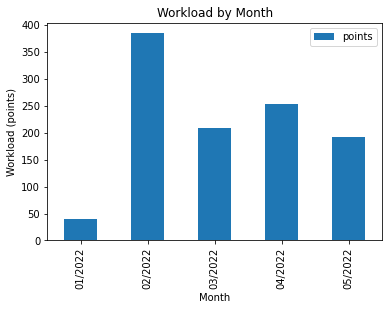

In [47]:
assignments_df = pd.DataFrame(assignments, columns=['name', 'due_date', 'points'])
assignments_df['due_date'] = pd.to_datetime(assignments_df['due_date'])
assignments_df = assignments_df.dropna()
assignments_df = assignments_df.set_index('due_date')
data = assignments_df.groupby(pd.Grouper(freq='M')).sum()
data.reset_index(inplace=True)
data['due_date'] = data['due_date'].apply(lambda x: x.strftime("%m/%Y"))
data.plot.bar(x='due_date', y='points', title='Workload by Month', xlabel='Month', ylabel='Workload (points)')

## Summary and References
This tutorial introduced the basic of REST APIs and how we can use APIs to gather data or transfer data across applications with Python. The following links are the documentations for the resources used. 

1. Requests: https://docs.python-requests.org/en/latest/
2. Random: https://docs.python.org/3/library/random.html
3. html2text: https://github.com/Alir3z4/html2text/blob/master/docs/usage.md
4. Canvas LMS API: https://canvas.instructure.com/doc/api/index.html
5. Trello API: https://developer.atlassian.com/cloud/trello/rest/api-group-actions/